Ising transverse large fields, n=2...

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import warnings
from collections import deque
import random
from vans_gym.envs import VansEnv
from vans_gym.solvers import CirqSolver
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import os 
tf.keras.backend.set_floatx('float64')
warnings.filterwarnings('ignore')

class Critic(tf.keras.Model):
    def __init__(self,tau=0.05, seed_val = 0.05, output_dim=4):
        super(Critic,self).__init__()

        self.tau = tau
        self.output_dim = output_dim
        
        #self.input_layer = tf.keras.Input(shape=())

        self.l1 = Dense(60)#,kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l2 = Dense(60)#, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l3 = Dense(output_dim)#, kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val)) #n_actions in the alphabet



    def update_target_parameters(self,primary_net):
        prim_weights = primary_net.get_weights()
        targ_weights = self.get_weights()
        weights = []
        for i in tf.range(len(prim_weights)):
            weights.append(self.tau * prim_weights[i] + (1 - self.tau) * targ_weights[i])
        self.set_weights(weights)
        return

    def give_action(self,state, ep=0.01, more_states=1):
        if np.random.random() < ep:
            random_action = np.random.choice(range(self.output_dim))
            return random_action
        else:
            qvals = np.squeeze(self(tf.expand_dims(state, axis=0)))
            action_gredy = np.random.choice(np.where(qvals == np.max(qvals))[0])
            return action_gredy
    
    def call(self, inputs):
        feat = tf.nn.sigmoid(self.l1(inputs))
        feat = tf.nn.sigmoid(self.l2(feat))
        feat = tf.nn.sigmoid(self.l3(feat))
        return tf.multiply(2.0,feat)



class ReplayBuffer():
    def __init__(self, buffer_size=10**6):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, experience):
        if not isinstance(experience, tuple):
            raise ValueError("buffer wants tuples!")
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        batch = []
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, int(batch_size))
        return batch
    
    def clear(self):
        self.buffer.clear()
        self.count = 0

        
        
def learning_step(critic, critic_target, buffer, optimizer, batch_size=30):
    batch =buffer.sample(batch_size)
    states, actions, next_states, rewards, dones = np.transpose(batch)

    qpreds = critic(tf.stack(states))
    labels = qpreds.numpy()
    for inda, act in enumerate(actions):
        if dones[inda] is False:
            labels[inda,act] = np.max(np.squeeze(critic_target(tf.expand_dims(next_states[inda], axis=0))))
        else:
            labels[inda, act] = rewards[inda]
            
    
    with tf.GradientTape() as tape:
        tape.watch(critic.trainable_variables)
        qpreds = critic(tf.stack(states))

        loss = tf.keras.losses.MSE(labels, qpreds)
        loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, critic.trainable_variables)
    optimizer.apply_gradients(zip(grads, critic.trainable_variables))
    critic_target.update_target_parameters(critic)
    return loss.numpy()
    

In [40]:
buffer = ReplayBuffer()
solver = CirqSolver(n_qubits = 2 ,observable_name="Ising_High_TFields_HX")


In [41]:
critic = Critic(output_dim=len(solver.alphabet))
critic_target = Critic(output_dim=len(solver.alphabet), tau=0.01)
env = VansEnv(solver,maximum_number_of_gates=solver.n_qubits, state_as_sequence=True, printing=False)
env.reset()
critic(tf.expand_dims(env.state, axis=0))
critic_target(tf.expand_dims(env.state, axis=0))
optimizer = tf.keras.optimizers.Adam(lr=0.01)



If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [42]:
r=[]
pt=[]
lhist=[]
cumre=0
episodes = np.arange(1,10**3,1)

rhist=[]
action_hist=[]
tt = .75*len(episodes)/np.log(1/0.05)
def schedule(k):
    return max(0.05, np.exp(-k/tt))

#generate big buffer
for k in tqdm(episodes):
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=1)#schedule(k))
        action_hist.append(action)
        next_state, reward, done, info = env.step(action)
        buffer.add((state, action, next_state, reward, done))
        state = next_state
    cumre+=reward
    r.append(cumre)
    lhist.append(learning_step(critic, critic_target, buffer, optimizer, batch_size=64))
    
#     ####greedy prob#####
    state = env.reset()
    done = False
    while not done:
        action = critic.give_action(state, ep=0)
        next_state, reward, done, info = env.step(action)
        state = next_state
    #if (k>10**3):
    pt.append(reward)

100%|██████████| 999/999 [01:05<00:00, 15.15it/s]


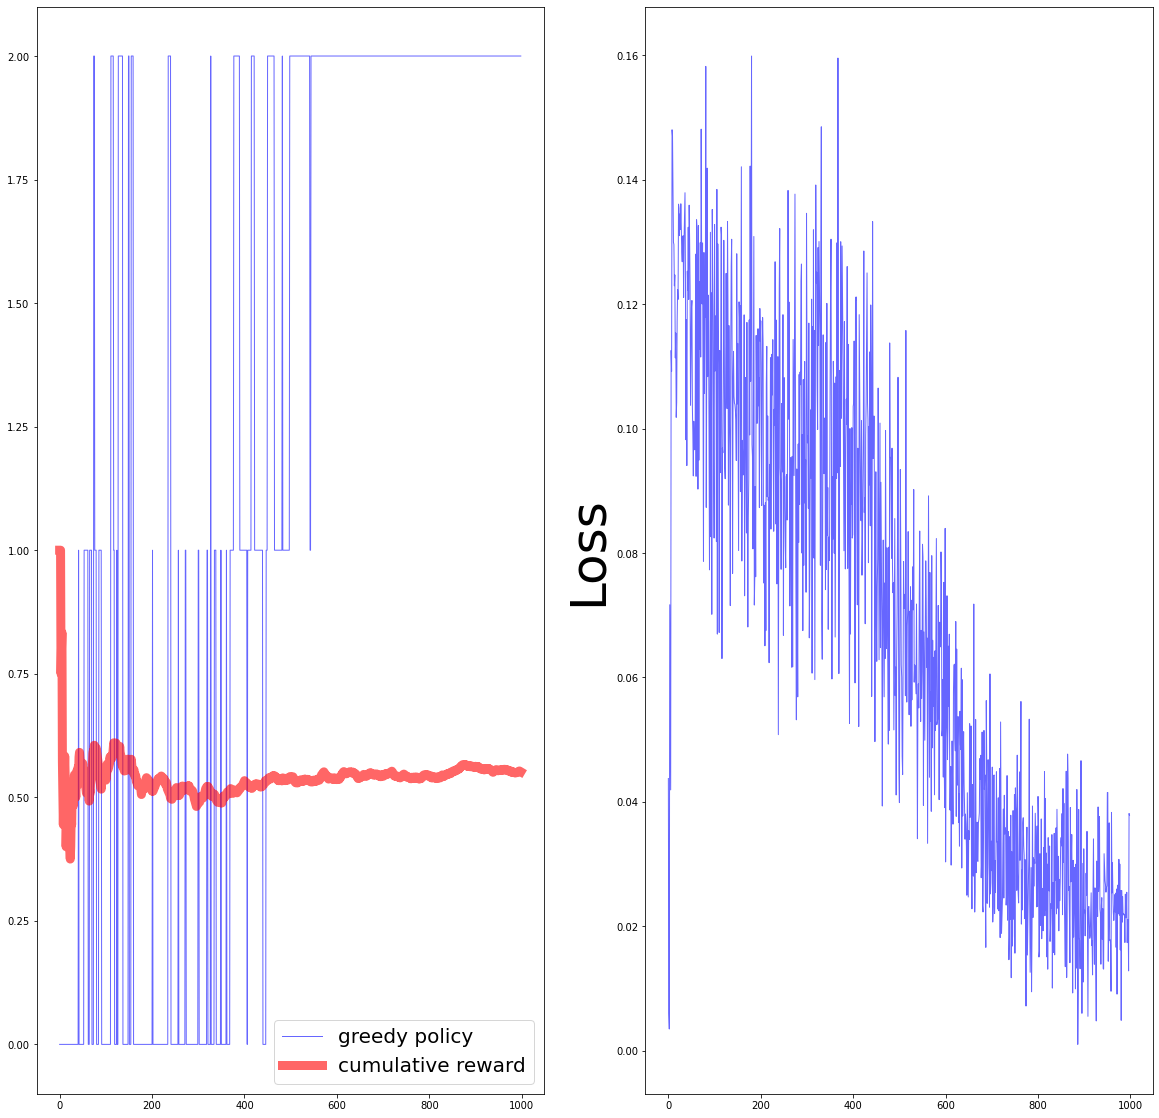

In [43]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))


ax1.plot(pt, alpha=0.6,c="blue", linewidth=1,label="greedy policy")
ax1.plot(r/episodes, alpha=0.6, linewidth=9,c="red",label="cumulative reward")
ax2.set_ylabel("Loss", size=50)
ax2.plot(range(len(lhist)), lhist, alpha=0.6, linewidth=1,c="blue",label="critic loss")
ax1.legend(prop={"size":20})

